In [1]:
# Ref: https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Bidirectional, Embedding, LSTM, SpatialDropout1D, Input, Concatenate, GaussianNoise
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import os
import io
from nltk.corpus import stopwords
import tensorflow as tf
from bs4 import BeautifulSoup

## Read data

In [9]:
import nltk
from preprocessing import preprocess_text

In [10]:
data = pd.read_csv("../Database/ISEAR/isear_databank.csv")
data = data[['Field1', 'SIT']]
text_col = 'Field1'
data = preprocess_text(data,text_col)
data.head()

,index,Field1,SIT,CleanMsg
0,0,joy,"During the period of falling in love, each tim...",[joy]
1,1,fear,When I was involved in a traffic accident.,[fear]
2,2,anger,When I was driving home after several days of...,[anger]
3,3,sadness,When I lost the person who meant the most to me.,[sadness]
4,4,disgust,The time I knocked a deer down - the sight of ...,[disgust]


In [11]:
for i in data.Field1.unique():
    print(len(data.loc[data[text_col] == i]),i)

1094 joy
1095 fear
1096 anger
1096 sadness
1096 disgust
1096 shame
1093 guilt


## Create embedding layer

In [12]:
def getEmbeddings(file):
    embeddingsIndex = {}
    dim = 0
    with io.open(file, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            embeddingVector = np.asarray(values[1:], dtype='float32')
            embeddingsIndex[word] = embeddingVector 
            dim = len(embeddingVector)
    return embeddingsIndex, dim

In [13]:
embeddings, dim = getEmbeddings("../glove/glove.6B.100d.txt")

In [14]:
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts([' '.join(list(embeddings.keys()))])
word_index = tokenizer.word_index

In [15]:
embedding_matrix = np.zeros((len(word_index) + 1, dim))
for word, i in word_index.items():
    embedding_matrix[i] = embeddings.get(word)

## Dataset

In [257]:
# Max number of words in each dialogue.
MAX_SEQUENCE_LENGTH = 160

In [258]:
X = tokenizer.texts_to_sequences(data['SIT'].values)
print(np.max([len(k) for k in X]))
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

157
Shape of data tensor: (7666, 160)


In [259]:
#TODO: apply the column for data Y
Y = pd.get_dummies(data[ 'Field1']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (7666, 7)


In [283]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.050, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7282, 160) (7282, 7)
(384, 160) (384, 7)


## Build MOdel

In [295]:
embedding_dim = embedding_matrix.shape[1]
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(GaussianNoise(0.1, input_shape=(None, MAX_SEQUENCE_LENGTH, embedding_dim)))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, dropout=0.2)))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 160, 100)          40000100  
_________________________________________________________________
gaussian_noise_41 (GaussianN (None, 160, 100)          0         
_________________________________________________________________
spatial_dropout1d_21 (Spatia (None, 160, 100)          0         
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 128)               84480     
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 30)                3870      
_________________________________________________________________
dense_85 (Dense)             (None, 7)               

# Training Data

In [296]:
epochs = 30
batch_size = 50
history = model.fit(X_train,Y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, Y_test), verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.005, restore_best_weights=True)])

Epoch 1/30
146/146 [==============================] - 2s 15ms/step - loss: 1.9284 - accuracy: 0.1741 - val_loss: 1.8750 - val_accuracy: 0.2214
Epoch 2/30
146/146 [==============================] - 2s 12ms/step - loss: 1.8490 - accuracy: 0.2523 - val_loss: 1.7122 - val_accuracy: 0.3229
Epoch 3/30
146/146 [==============================] - 2s 12ms/step - loss: 1.7651 - accuracy: 0.3071 - val_loss: 1.6309 - val_accuracy: 0.3724
Epoch 4/30
146/146 [==============================] - 2s 12ms/step - loss: 1.7019 - accuracy: 0.3484 - val_loss: 1.5915 - val_accuracy: 0.4089
Epoch 5/30
146/146 [==============================] - 2s 12ms/step - loss: 1.6331 - accuracy: 0.3800 - val_loss: 1.5321 - val_accuracy: 0.4505
Epoch 6/30
146/146 [==============================] - 2s 12ms/step - loss: 1.5784 - accuracy: 0.4055 - val_loss: 1.4688 - val_accuracy: 0.4714
Epoch 7/30
146/146 [==============================] - 2s 12ms/step - loss: 1.5316 - accuracy: 0.4297 - val_loss: 1.4056 - val_accuracy: 0.4714

In [297]:
accr = model.evaluate(X_test,Y_test)
print(accr)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

12/12 [==============================] - 0s 5ms/step - loss: 1.1799 - accuracy: 0.6146
[1.1799129247665405, 0.6145833134651184]
Test set
  Loss: 1.180
  Accuracy: 0.615


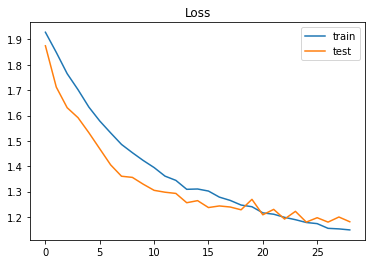

In [298]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [299]:
#history.history

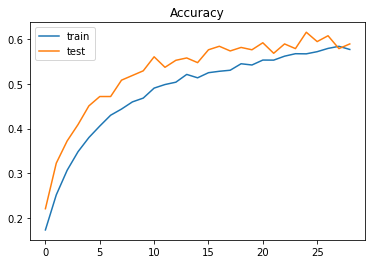

In [300]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();